# PCA on Faces Dataset

In this assignment, we will use PCA for dimensionality reduction on the MIT Face Recognition Dataset (https://courses.media.mit.edu/2004fall/mas622j/04.projects/faces/). The following code collects images from rawdata and stores them in a 128x128x(number of images) tensor - image_collection.

See the following link for how to use PCA in scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html


In [1]:
import os
import skimage
import numpy as np
import matplotlib.pyplot as plt
import skimage.measure

IMAGE_SIZE = 128
directory  = os.fsencode('rawdata/')
num_files  = len([file for file in os.listdir(directory) \
                  if os.path.isfile(os.path.join(directory, file))])
image_collection = np.zeros((IMAGE_SIZE,IMAGE_SIZE,num_files))
count = 0

for file in os.listdir(directory):
    filename   = os.fsdecode(file)
    temp_image = np.fromfile('rawdata/'+filename, dtype='uint8', sep="")
    ratio      = temp_image.shape[0]/(IMAGE_SIZE*IMAGE_SIZE)
    if ratio > 1:
        temp_image = np.reshape(temp_image, (IMAGE_SIZE*int(np.sqrt(ratio)), IMAGE_SIZE*int(np.sqrt(ratio))))
        temp_image = skimage.measure.block_reduce(temp_image, (int(np.sqrt(ratio)),int(np.sqrt(ratio))), np.mean)
    image_collection[:,:,count] = np.reshape(temp_image,(IMAGE_SIZE,IMAGE_SIZE))
    count += 1

image_collection = image_collection[:,:,:count]

# Problem 1

Recall that PCA requires centered data(zero mean). Center B and display the mean image in gray scale using matplotlib

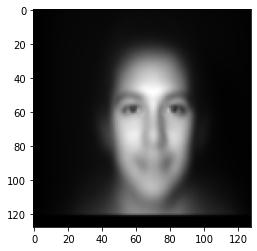

In [2]:
#========Your code here ======

mean = np.mean(image_collection, axis=2)
image_collection = image_collection - mean.reshape(mean.shape[0], mean.shape[1], 1)

#==============================
plt.imshow(mean, cmap='gray')

# Problem 2

Perform PCA on the images using sklearn. Plot the total percentage of variance explained versus number of components. Finally plot the singular values when number of components is 500. Justify the plots.

### Answer:
From the plot, we can see that as the number of component increases, the total percentage of the variance also increases. However, when the number of components increased to a certain level, it began to flatten the growth. The singular values corresponding to each selected components. Both plots shows that we have to choose a proper number of components, if the number of components we choose is too large, we may have a relatively low variance. So we need to find the proper number of components for best performance.

In [3]:
image_collection.reshape(IMAGE_SIZE*IMAGE_SIZE,image_collection.shape[2]).shape

(16384, 3993)

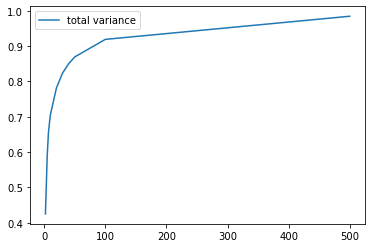

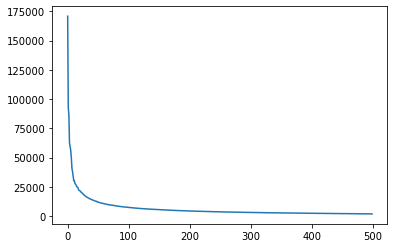

In [6]:
num_comp = [2,5,7,10,20,30,40,50,100,500]
#========Your code here ======
from sklearn.decomposition import PCA
total_variance_explained = []
img_col = image_collection.reshape(IMAGE_SIZE * IMAGE_SIZE, image_collection.shape[2])
for i in range(len(num_comp)):
    pca = PCA(n_components=num_comp[i])
    pca.fit(img_col.T)
    total_variance_explained.append(np.sum(pca.explained_variance_ratio_))
    if num_comp[i] == 500:
        singular_values = pca.singular_values_
#==============================
plt.figure(1)
plt.plot(num_comp,total_variance_explained,label='total variance')
plt.legend()
plt.show()
plt.figure(2)
plt.plot(range(500),singular_values)
plt.show()

# Problem 3

Display the first 5 principal components as images in gray scale using matplotlib. Explain your observations.

### Answer:
From the first plot, we can see that the appearnce and the outline of the face is still clear. In the second plot, it seems like it is the contrast image to the first plot. In the third plot, we can observe that the outline of the face is unclear excepth the forehead. Observing the all five plots we can conclude that with less components, we can see the plot more clearly, this is obvious since it chose less components, we can visually receive more information from the plot.

In [5]:
pca.components_[0].shape

(16384,)

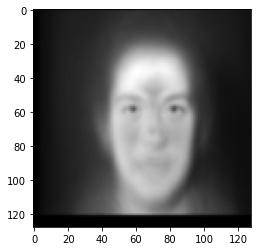

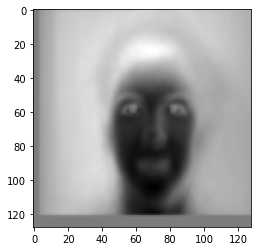

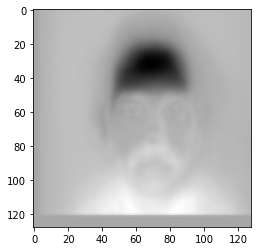

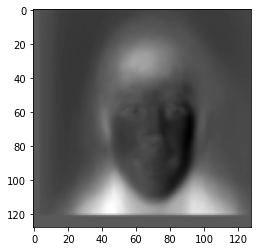

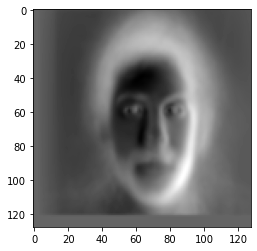

In [6]:
#========Your code here ======
plt.figure(1)
plt.imshow(pca.components_[0].reshape(IMAGE_SIZE, IMAGE_SIZE),cmap='gray')

plt.figure(2)
plt.imshow(pca.components_[1].reshape(IMAGE_SIZE, IMAGE_SIZE),cmap='gray')

plt.figure(3)
plt.imshow(pca.components_[2].reshape(IMAGE_SIZE, IMAGE_SIZE),cmap='gray')

plt.figure(4)
plt.imshow(pca.components_[3].reshape(IMAGE_SIZE, IMAGE_SIZE),cmap='gray')

plt.figure(5)
plt.imshow(pca.components_[4].reshape(IMAGE_SIZE, IMAGE_SIZE),cmap='gray')

#==============================

# K-means for Image Quantization

In this part of the assignment you will implement your own k-means algorithm and use it for image quantization. 

As we know image consists of pixels. For standard colored image, each pixel is a 3D vector where each component is an integer from 0 to 255 which represents the intensity of red, green and blue light. 

Sometimes we may want to reduce the number of colors in an image. One naive way is to simply reduce the quantization bits of pixels: instead of using 0-255 which could be written as 8 bit binary, we simply reduce the number of bits (for example, using 4 bits means that we use integers 0-15 instead). However, this method may not capture the original color of the image as you will see in an example.

K-means provides a better alternative: we treat each pixel as a vector, and try to find $k$ colors (centroids) that best represent the colors in the image. 

The following code reads an image and converts it to a set of vectors. You may need to install OpenCV for python. To install, simply run `pip install opencv-python` in your terminal/Anaconda prompt

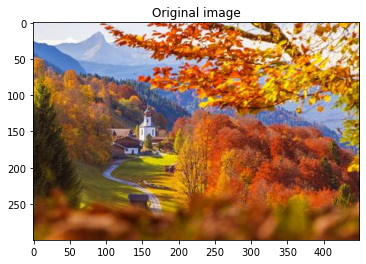

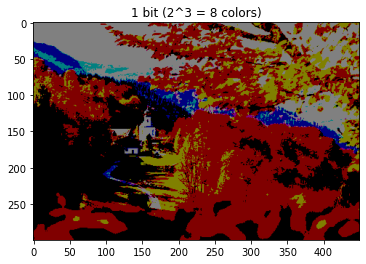

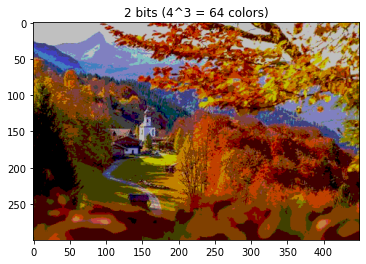

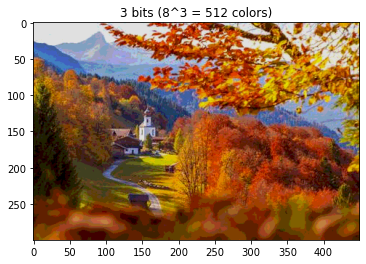

In [7]:
import matplotlib.pyplot as plt
import cv2

img = cv2.imread("image.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Some useful parameters
height = img.shape[0]
width = img.shape[1]
n = height * width

# Reshaping the image into vectors. 
vec_img = img.reshape((-1, 3))
vec_img = np.float32(vec_img)

# Display original and quantized images. 
plt.figure()
plt.title("Original image")
plt.imshow(img)

plt.figure()
quantized_img = np.uint8(np.float32(img)/128)*128
plt.title("1 bit (2^3 = 8 colors)")
plt.imshow(quantized_img)

quantized_img = np.uint8(np.float32(img)/64)*64
plt.figure()
plt.title("2 bits (4^3 = 64 colors)")
plt.imshow(quantized_img)

quantized_img = np.uint8(np.float32(img)/32)*32
plt.figure()
plt.title("3 bits (8^3 = 512 colors)")
plt.imshow(quantized_img)


# Problem 4: Implement your own k-means algorithm

Now you will implement your own k-means algorithm. Random initialization of centroids is sufficient for this assignment. You are NOT allowed to use any k-means imlementations in any existing libraries, including but not limited to those in OpenCV and Scikit-learn. Your algorithm takes the following input:

$K$ - the number of clusters/centroids

$vec$ - the set of vectors ($n\times d$ array where $n$ is the number of vectors and $d$ is the dimension of each vector)

$eps$ - algorithm should stop when the average distance change of centroids is smaller than this number. More specifically, let $c_k^{(i)}$ be the $k$'th centroid in iteration $i$, the algorithm should stop when:
$$
\frac{1}{K}\sum_{k=1}^K \|c_k^{(i)}-c_k^{(i-1)}\|^2<eps
$$
$max\_iter$ - maximum number of iterations

Your algorithm should stop when either of the two criteria (change of centroids less than $eps$, or maximum iteration) is satisfied. 

It should return two values:

$centroids$ - the centroids for each cluster arranged in a $K\times d$ array

$labels$ - the labels of each vector, an $n$ dimensional 1-d array. Each label should be an integer from $\{0, ..., K-1\}$

In [8]:
vec_img.shape

(135000, 3)

In [9]:
import random
from numpy import linalg as la
def k_means(vec, K, eps, max_iter):
    n = vec.shape[0]
    d = vec.shape[1]
    centroids = np.zeros((K, d))
    labels = np.zeros(n).astype(int)
    
    #============ Your code here ====================
    # randomly pick k data points as initial centroids
    for i in range(K):
        centroids[i,:] = vec[int(n*i/K), :]
    
    iterator = 0
    # start the steps until it reaches max_iter or centroids converges
    while iterator < max_iter:
        iterator += 1
        min_dis = np.array(np.zeros([n,K]))
        # find the distance between each data points int k centroids
        for i in range(K):
            c = centroids[i,:]
            min_dis[:,i] = np.linalg.norm(vec - c,axis=1)
        pre = np.copy(centroids)
        # assign each data point to the closest centroid with minimun distance
        index = min_dis.argmin(axis=1)
        for k in range(K):
            # update centroids by taking mean of cluster it belongs to
            m = np.mean(vec[(index==k), :], axis=0)
            centroids[k,:] = m
        #if the centroids converge, stop the loop
        if np.sum((pre-centroids)**2)/K < eps:
            break
            
    for i in range(K):
        c = centroids[i]
        min_dis[:,i] = np.linalg.norm(vec-c,axis=1)
    labels = min_dis.argmin(axis=1)
    #=============== End code =====================

    return centroids, labels


Now comes the fun part: display the quantized image for $K=4, 8, 16, 32$. You will observe that k-means quantization achieves far better results than the naive quantization strategy with much less number of colors. 

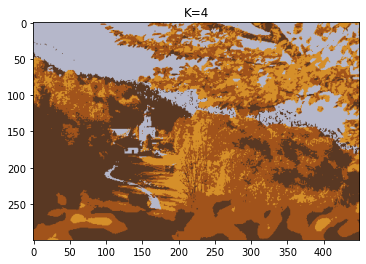

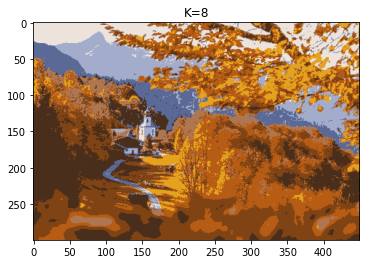

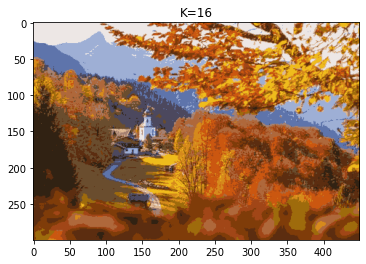

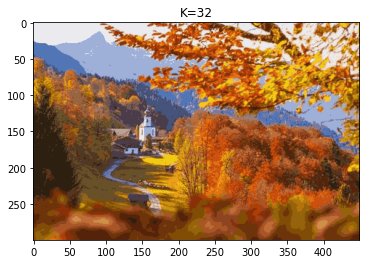

In [10]:
K = [4, 8, 16, 32]
eps = 1e-6
max_iter = 10000

for k in K:
    plt.figure()
    centroids, labels = k_means(vec_img, k, eps, max_iter)
    compressed_vec = centroids[labels, :]
    compressed_img = compressed_vec.reshape(img.shape)
    compressed_img = np.uint8(compressed_img)
    plt.imshow(compressed_img)
    plt.title("K=" + str(k) )

# Problem 5: Try with your own image (this part is not graded)

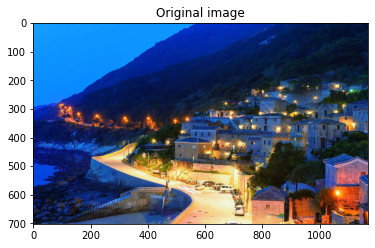

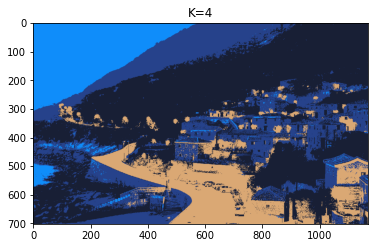

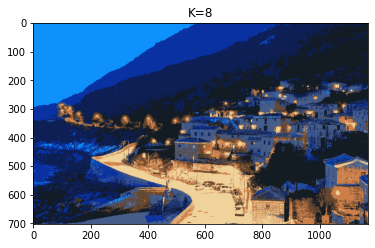

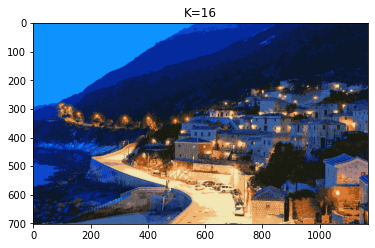

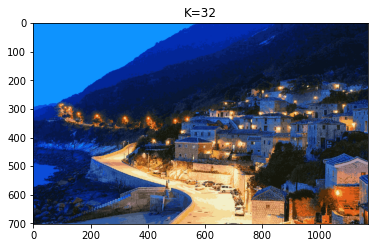

In [11]:
img = cv2.imread("matsu.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

height = img.shape[0]
width = img.shape[1]
n = height * width

vec_img = img.reshape((-1, 3))
vec_img = np.float32(vec_img)

plt.figure()
plt.title("Original image")
plt.imshow(img)

K = [4, 8, 16, 32]
eps = 1e-2
max_iter = 10000

for k in K:
    plt.figure()
    centroids, labels = k_means(vec_img, k, eps, max_iter)
    compressed_vec = centroids[labels, :]
    compressed_img = compressed_vec.reshape(img.shape)
    compressed_img = np.uint8(compressed_img)
    plt.imshow(compressed_img)
    plt.title("K=" + str(k) )